Analysis complete - check generated files!


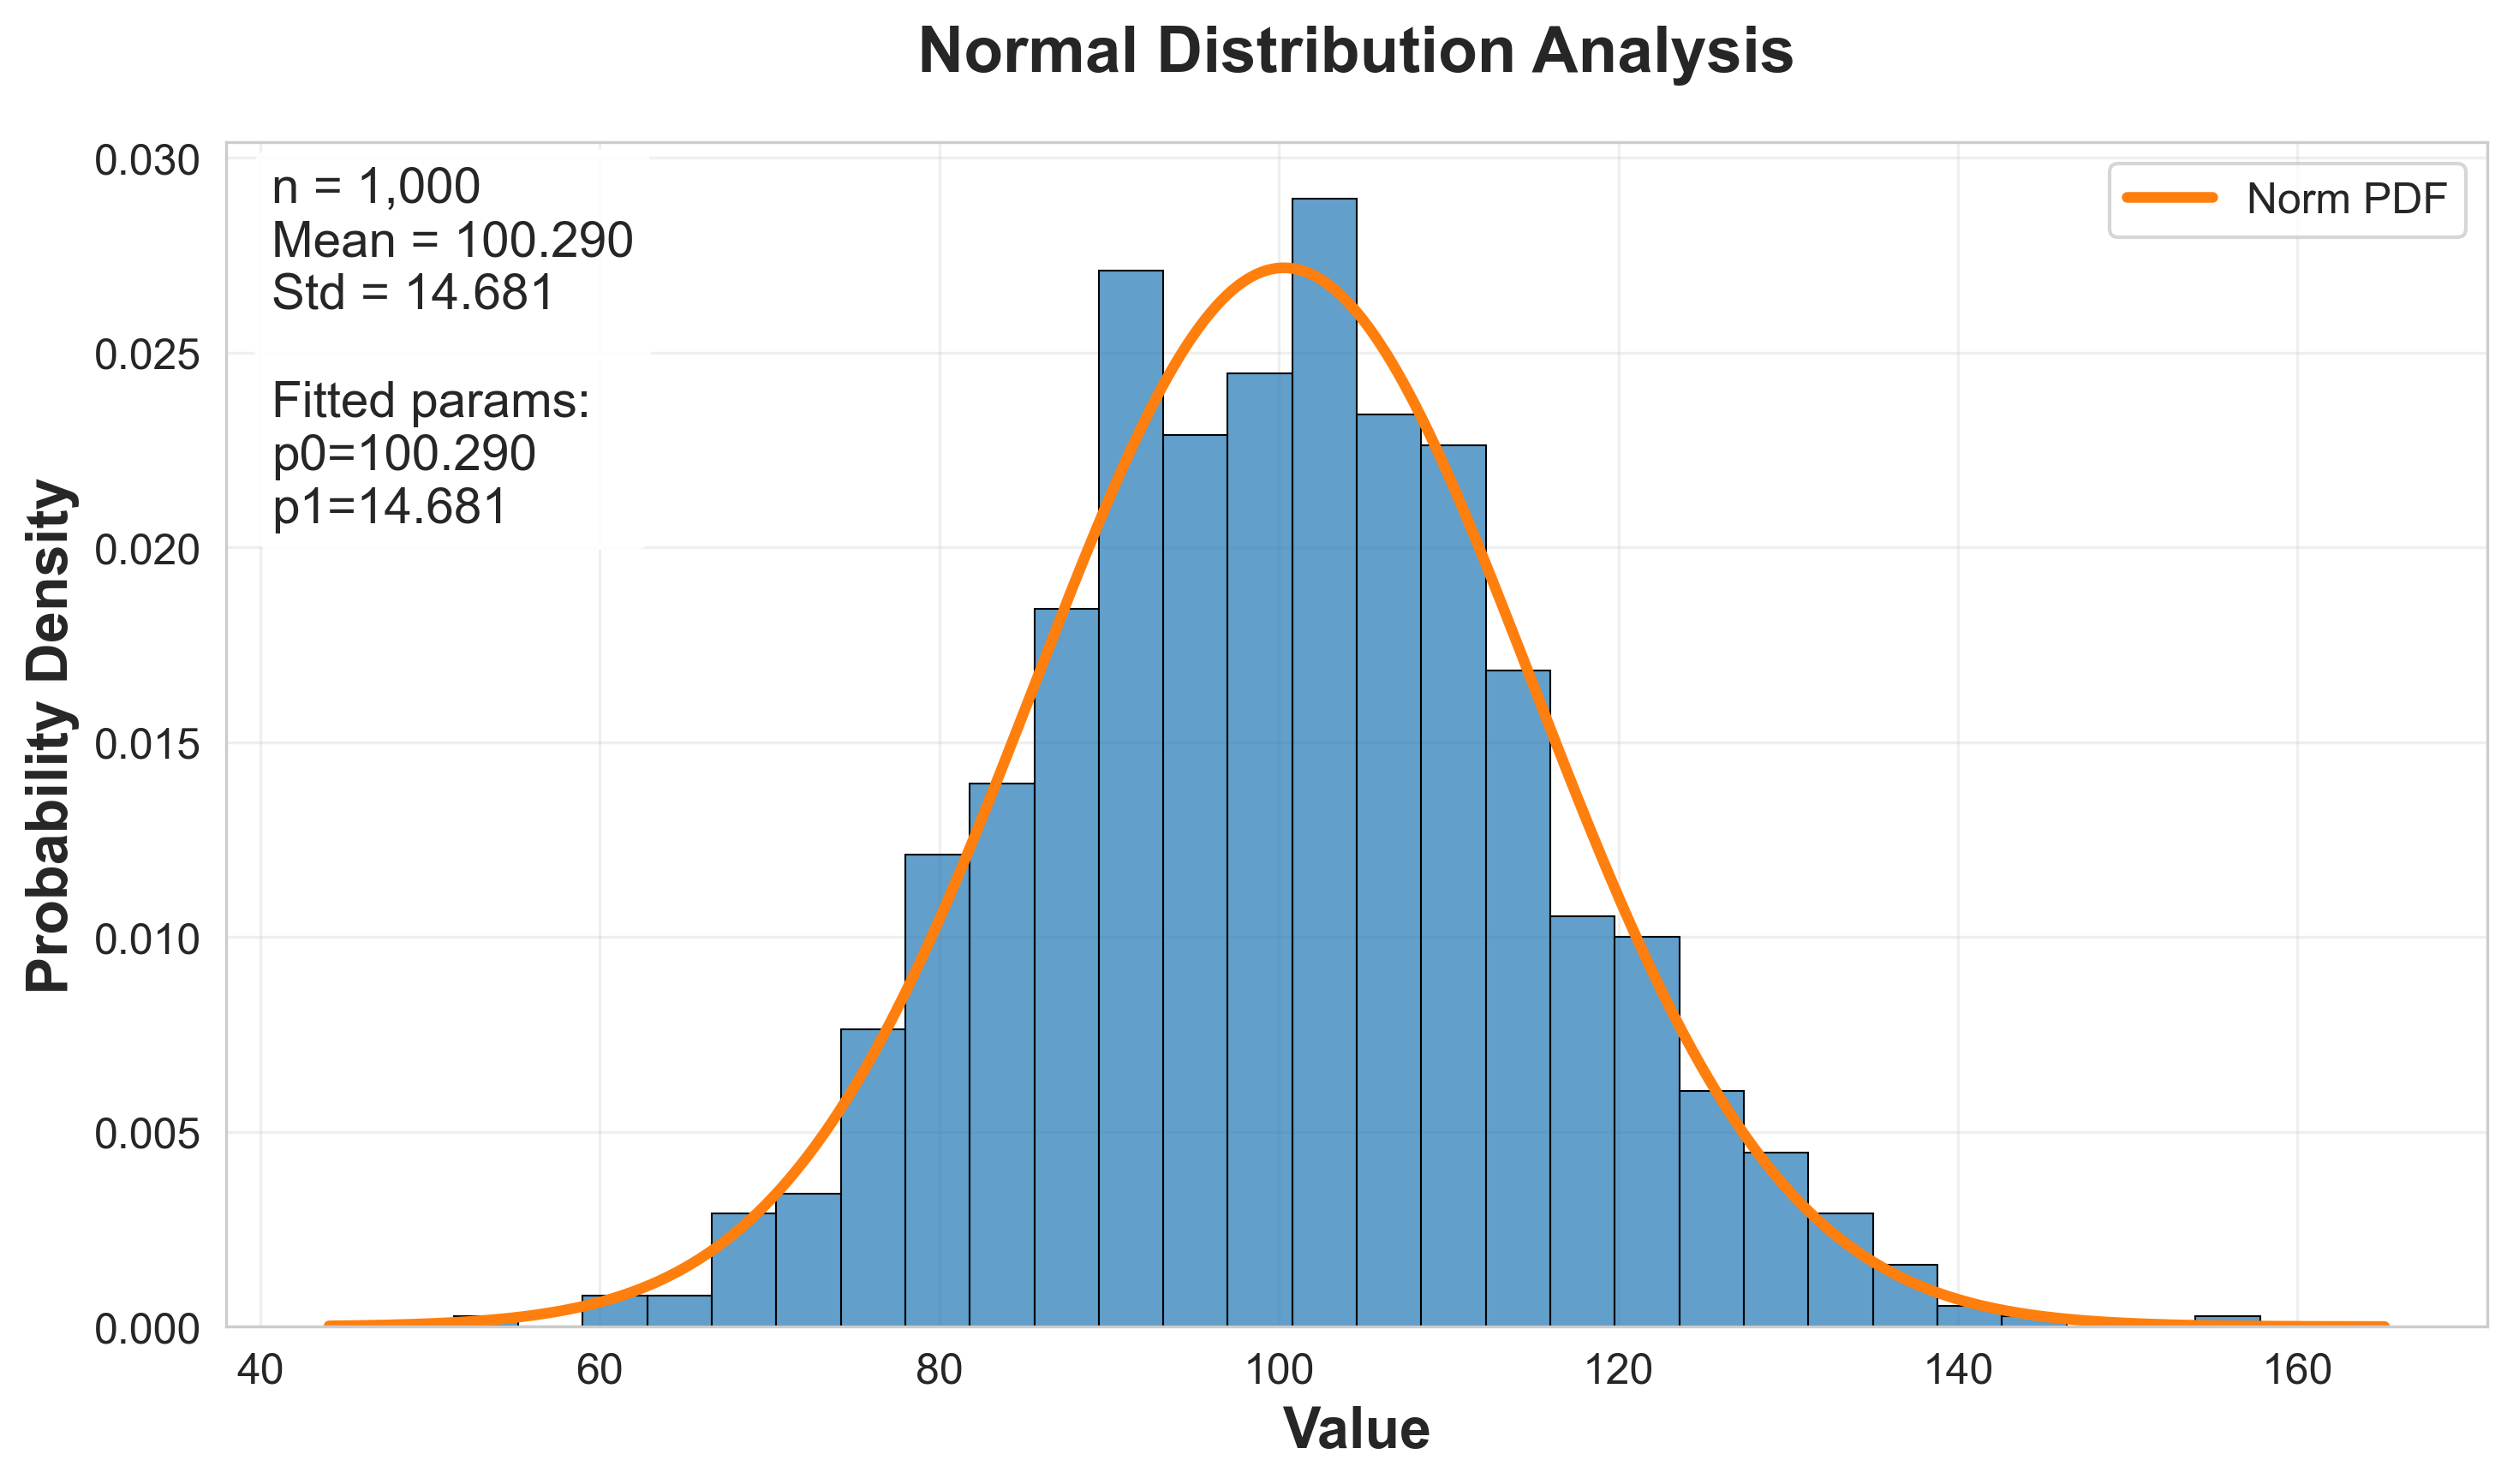

In [ ]:
import warnings
from functools import lru_cache
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns

# Professional font configuration
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.titlesize": 20,
    }
)


class StatisticalPlotter:
    """
    Production-ready class for creating histogram and PDF overlay plots
    with comprehensive error handling and optimization
    """

    def __init__(self, style="seaborn", dpi=300):
        self.style = style
        self.dpi = dpi
        self._setup_styling()

    def _setup_styling(self):
        """Configure publication-ready styling"""
        if self.style == "seaborn":
            sns.set_style("whitegrid")
            plt.rcParams.update(
                {
                    "font.size": 14,
                    "axes.labelsize": 16,
                    "figure.dpi": self.dpi,
                    "savefig.dpi": self.dpi,
                    "font.family": "sans-serif",
                }
            )

    def _validate_and_clean_data(self, data: np.ndarray) -> np.ndarray:
        """Robust data validation and cleaning"""
        data = np.asarray(data).flatten()

        # Handle missing values
        finite_mask = np.isfinite(data)
        if not np.all(finite_mask):
            warnings.warn(f"Removed {np.sum(~finite_mask)} non-finite values")
            data = data[finite_mask]

        if len(data) == 0:
            raise ValueError("No valid data points after cleaning")

        if np.std(data) == 0:
            warnings.warn("All data points are identical - PDF overlay not meaningful")

        return data

    @lru_cache(maxsize=32)
    def _cached_distribution_fit(self, data_hash: int, dist_name: str):
        """Cache expensive distribution fitting operations"""
        # In practice, you'd need to implement proper hashing for numpy arrays
        pass

    def create_plot(
        self,
        data: Union[np.ndarray, list],
        distribution: stats.rv_continuous = stats.norm,
        bins: Union[int, str] = "auto",
        plot_type: str = "seaborn",
        title: Optional[str] = None,
        xlabel: str = "Value",
        ylabel: str = "Probability Density",
        figsize: Tuple[int, int] = (10, 6),
        color_scheme: str = "viridis",
        save_path: Optional[str] = None,
        **kwargs,
    ) -> Tuple[Union[plt.Figure, go.Figure], dict]:
        """
        Create histogram with PDF overlay using specified backend

        Parameters:
        -----------
        data : array-like
            Input data for histogram
        distribution : scipy.stats distribution
            Distribution to fit and overlay
        bins : int or str
            Number of bins or binning strategy
        plot_type : str
            'seaborn', 'plotly', or 'matplotlib'
        title : str, optional
            Plot title
        xlabel, ylabel : str
            Axis labels
        figsize : tuple
            Figure size (width, height)
        color_scheme : str
            Color palette name
        save_path : str, optional
            Path to save figure

        Returns:
        --------
        figure : matplotlib.Figure or plotly.Figure
            The created figure
        params : dict
            Fitted distribution parameters
        """

        # Validate and clean data
        data = self._validate_and_clean_data(data)

        # Fit distribution with error handling
        try:
            fitted_params = distribution.fit(data)
        except Exception as e:
            warnings.warn(f"Distribution fitting failed: {e}")
            fitted_params = None

        # Create plot based on backend
        if plot_type.lower() == "plotly":
            return self._create_plotly_plot(
                data, distribution, fitted_params, bins, title, xlabel, ylabel, **kwargs
            )
        elif plot_type.lower() == "seaborn":
            return self._create_seaborn_plot(
                data,
                distribution,
                fitted_params,
                bins,
                title,
                xlabel,
                ylabel,
                figsize,
                color_scheme,
                save_path,
                **kwargs,
            )
        else:
            return self._create_matplotlib_plot(
                data,
                distribution,
                fitted_params,
                bins,
                title,
                xlabel,
                ylabel,
                figsize,
                save_path,
                **kwargs,
            )

    def _create_seaborn_plot(
        self,
        data,
        distribution,
        params,
        bins,
        title,
        xlabel,
        ylabel,
        figsize,
        color_scheme,
        save_path,
        **kwargs,
    ):
        """Create publication-ready Seaborn plot"""

        fig, ax = plt.subplots(figsize=figsize)

        # Color scheme handling
        if color_scheme == "viridis":
            colors = plt.cm.viridis(np.linspace(0.2, 0.8, 2))
        elif color_scheme == "colorblind":
            colors = ["#1f77b4", "#ff7f0e"]  # Colorblind-safe colors
        else:
            colors = plt.cm.Set2(np.linspace(0, 1, 2))

        # Create histogram
        sns.histplot(
            data=data,
            bins=bins,
            stat="density",
            alpha=0.7,
            color=colors[0],
            edgecolor="black",
            linewidth=0.5,
            ax=ax,
            **kwargs,
        )

        # Add PDF overlay if fitting succeeded
        if params is not None:
            x_theory = np.linspace(
                data.min() - 0.5 * np.std(data), data.max() + 0.5 * np.std(data), 500
            )
            pdf_theory = distribution.pdf(x_theory, *params)

            ax.plot(
                x_theory,
                pdf_theory,
                color=colors[1],
                linewidth=3,
                label=f"{distribution.name.title()} PDF",
            )

        # Styling
        ax.set_xlabel(xlabel, fontweight="bold")
        ax.set_ylabel(ylabel, fontweight="bold")
        if title:
            ax.set_title(title, fontweight="bold", pad=20)

        # Statistics box
        stats_text = (
            f"n = {len(data):,}\nMean = {np.mean(data):.3f}\nStd = {np.std(data):.3f}"
        )
        if params is not None:
            param_text = "Fitted params:\n" + "\n".join(
                [f"p{i}={p:.3f}" for i, p in enumerate(params)]
            )
            stats_text += f"\n\n{param_text}"

        ax.text(
            0.02,
            0.98,
            stats_text,
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
        )

        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=self.dpi, bbox_inches="tight")

        return fig, {
            "fitted_params": params,
            "data_stats": {"mean": np.mean(data), "std": np.std(data), "n": len(data)},
        }

    def _create_plotly_plot(
        self, data, distribution, params, bins, title, xlabel, ylabel, **kwargs
    ):
        """Create interactive Plotly plot"""

        fig = go.Figure()

        # Add histogram
        fig.add_trace(
            go.Histogram(
                x=data,
                nbinsx=bins if isinstance(bins, int) else 50,
                histnorm="probability density",
                name="Data",
                opacity=0.7,
                marker=dict(color="lightblue", line=dict(color="darkblue", width=1)),
                hovertemplate="<b>Range:</b> %{x}<br><b>Density:</b> %{y:.4f}<extra></extra>",
            )
        )

        # Add PDF if fitting succeeded
        if params is not None:
            x_theory = np.linspace(
                data.min() - 0.5 * np.std(data), data.max() + 0.5 * np.std(data), 500
            )
            pdf_theory = distribution.pdf(x_theory, *params)

            fig.add_trace(
                go.Scatter(
                    x=x_theory,
                    y=pdf_theory,
                    mode="lines",
                    name=f"{distribution.name.title()} PDF",
                    line=dict(color="red", width=3),
                    hovertemplate="<b>x:</b> %{x:.3f}<br><b>PDF:</b> %{y:.4f}<extra></extra>",
                )
            )

        # Professional styling
        fig.update_layout(
            title=dict(text=title or "Distribution Analysis", x=0.5, font_size=20),
            xaxis=dict(title=xlabel, title_font_size=16, tickfont_size=14),
            yaxis=dict(title=ylabel, title_font_size=16, tickfont_size=14),
            plot_bgcolor="white",
            paper_bgcolor="white",
            font_family="Arial",
            hovermode="closest",
        )

        return fig, {
            "fitted_params": params,
            "data_stats": {"mean": np.mean(data), "std": np.std(data), "n": len(data)},
        }


# Usage examples
if __name__ == "__main__":
    # Initialize plotter
    plotter = StatisticalPlotter()

    # Generate example data
    np.random.seed(42)
    normal_data = np.random.normal(100, 15, 1000)
    exponential_data = np.random.exponential(2, 1000)

    # Create static plot
    fig_static, results_static = plotter.create_plot(
        normal_data,
        distribution=stats.norm,
        plot_type="seaborn",
        color_scheme="colorblind",
        title="Normal Distribution Analysis",
        save_path="normal_analysis.png",
    )

    # Create interactive plot
    fig_interactive, results_interactive = plotter.create_plot(
        exponential_data,
        distribution=stats.expon,
        plot_type="plotly",
        title="Exponential Distribution Analysis",
    )

    fig_interactive.show()

    print("Analysis complete - check generated files!")